## prepare model

In [2]:
ctx = mx.gpu()
backbone_root_path = r'd:/Documents/Data_Files/Parameters/'
ssd = SSD_origin.SSD(backbone_root_path=backbone_root_path, ctx=ctx)
ssd.hybridize()
tensor_pred = ssd(mx.nd.zeros((2, 3, 300, 300), ctx=ctx))
print('tensor_pred shape:', tensor_pred.shape)
print('anchors shape:', ssd.get_anchors().shape)

tensor_pred shape: (2, 11532, 25)
anchors shape: (11532, 4)


## prepare dataset

In [3]:
# dataset for training
root_path = r'D:\Documents\Data_Files\Datasets\Pascal\VOC2012'
dataset = myutils.Dataset(root_path=root_path, mode='train')
mx_dataset = dataset.transform(ssd.get_transform_fn())
print('Number of entries in training dataset:', len(dataset))

# dataset for validation
dataset_val = myutils.Dataset(root_path, mode='val')
print('Number of entries in validation dataset:', len(dataset_val))

Number of entries in training dataset: 5717
Number of entries in validation dataset: 5823


## create dataloader

In [4]:
# dataloader for training
batch_size = 5
dataloader = mx.gluon.data.DataLoader(dataset.transform((ssd.get_transform_fn())), 
                                      batch_size=batch_size, shuffle=False, last_batch='rollover', 
                                      batchify_fn=myutils.batchify_fn)
mx_imgs, mx_labels = next(iter(dataloader))
print('batch images shape:', mx_imgs.shape)
print('batch labels shape:', mx_labels.shape)

# dataloader for validation
batch_size_val = 4
dataloader_val = mx.gluon.data.DataLoader(dataset_val.transform(ssd.get_transform_fn_val()), 
                                          batch_size=batch_size_val, shuffle=False, last_batch='keep',
                                          batchify_fn=myutils.batchify_fn_val_2)

batch images shape: (5, 3, 300, 300)
batch labels shape: (5, 5, 5)


## !-- create mini-batch dataloader

In [5]:
sampler_mini = dataset_utils.MiniSampler(len(dataset), 100)
dataloader_mini = mx.gluon.data.DataLoader(dataset.transform((ssd.get_transform_fn())), 
                                      batch_size=batch_size, sampler=sampler_mini, last_batch='rollover', 
                                      batchify_fn=myutils.batchify_fn)
dataloader = dataloader_mini

sampler_mini_val = dataset_utils.MiniSampler(len(dataset_val), 100)
dataloader_val_mini = mx.gluon.data.DataLoader(dataset_val.transform(ssd.get_transform_fn_val()), 
                                          batch_size=batch_size_val, sampler=sampler_mini_val, last_batch='keep',
                                          batchify_fn=myutils.batchify_fn_val_2)
dataloader_val = dataloader_val_mini

## training procedure

In [6]:
# define trainer
trainer = mx.gluon.Trainer(ssd.collect_params(), 'sgd', {'wd': 0.0005, 'momentum':0.9})
tarin_epoch = 20
trainer.set_learning_rate(0.005)
lr_scheduler = mx.lr_scheduler.PolyScheduler(tarin_epoch, 0.005, pwr=0.9)

In [7]:
metric = evaluation.PascalVocMetric(dataset.class_names, ssd.get_anchors(), SSD_origin.get_pred_scores_classes_and_boxes_for_matric)

In [8]:
importlib.reload(ssd_utils)
epoch_losses = []
aps = []
for epoch in range(tarin_epoch):
    epoch_loss = 0
    for i, (mx_imgs, mx_labels) in enumerate(dataloader):
        mx_imgs = mx_imgs.as_in_context(ssd.ctx)
        mx_labels = mx_labels.as_in_context(ssd.ctx)
        with mx.autograd.record():
            tensor_preds = ssd(mx_imgs)  # (b, N, 25)
            cls_preds = tensor_preds[:, :, :21]  # (b, N, 21)
            box_preds = tensor_preds[:, :, -4:]  # (b, N, 4)
            tensor_targs = ssd_utils.generate_target(mx.nd.array(ssd.get_anchors(), ctx=ssd.ctx).expand_dims(axis=0), 
                                                     cls_preds, mx_labels[:, :, -4:], mx_labels[:, :, 0], 
                                                     iou_thresh=0.5, neg_thresh=0.3, negative_mining_ratio=3, 
                                                     dynamic_sampling=True)
            sum_loss, _, _ = SSD_origin.ssd_loss(cls_preds, box_preds, *tensor_targs)
        sum_loss.backward()
        trainer.step(1)
        trainer.set_learning_rate(lr_scheduler(epoch))
        epoch_loss += sum(sum_loss).mean().asscalar()
        
        
        if i % 10 == 0:
            ssd_utils_test.test_ssd_loss(mx_imgs, mx_labels, ssd, 
                                         mx.nd.array(ssd.get_anchors(), ctx=ssd.ctx).expand_dims(axis=0), 
                                         ssd_utils.generate_target)
    aps.append(metric.calc_ap(ssd, dataloader_val))
    epoch_losses.append(epoch_loss)
    print('epoch %d, loss: %.4f, ap: %.4f' % (epoch, epoch_loss, aps[-1]))

loss_sum: 20.060886 loss_cls: 13.294876 loss_box: 6.7660103
loss_sum: 14.460763 loss_cls: 8.999537 loss_box: 5.4612255
epoch 0, loss: 311.5240, ap: 0.0177
loss_sum: 13.3615265 loss_cls: 6.4285707 loss_box: 6.9329557
loss_sum: 10.199502 loss_cls: 5.7870727 loss_box: 4.412429
epoch 1, loss: 234.1123, ap: 0.0854
loss_sum: 10.817905 loss_cls: 4.901182 loss_box: 5.9167237
loss_sum: 8.496662 loss_cls: 4.7853174 loss_box: 3.711345
epoch 2, loss: 207.4454, ap: 0.0748
loss_sum: 9.081252 loss_cls: 4.142705 loss_box: 4.938547
loss_sum: 8.654739 loss_cls: 4.3915153 loss_box: 4.263224
epoch 3, loss: 213.3192, ap: 0.1234
loss_sum: 8.188067 loss_cls: 3.8838372 loss_box: 4.3042307
loss_sum: 7.3226433 loss_cls: 4.084021 loss_box: 3.238622
epoch 4, loss: 178.6039, ap: 0.1846
loss_sum: 11.896577 loss_cls: 4.1356087 loss_box: 7.760968
loss_sum: 8.458903 loss_cls: 4.2805314 loss_box: 4.1783724
epoch 5, loss: 174.8275, ap: 0.1804
loss_sum: 8.490147 loss_cls: 3.8353436 loss_box: 4.6548038
loss_sum: 8.27196 l

img 0: positives: 60.0, negatives: 180.0


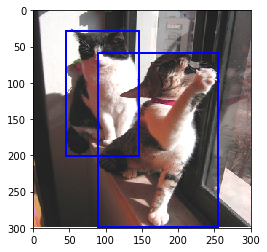

positive samples on each feature map:
anchor index: 0


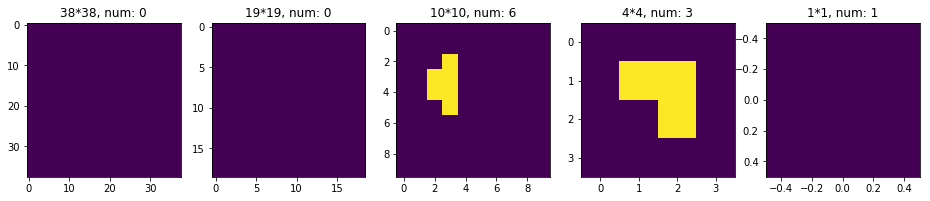

anchor index: 1


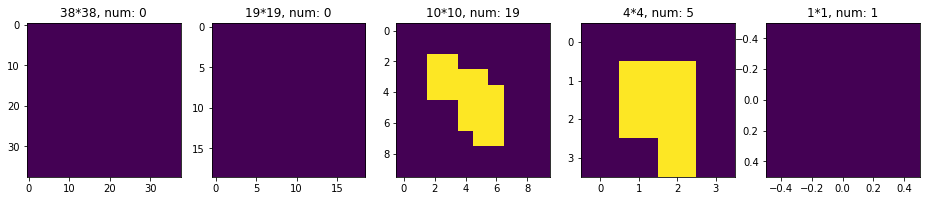

anchor index: 2


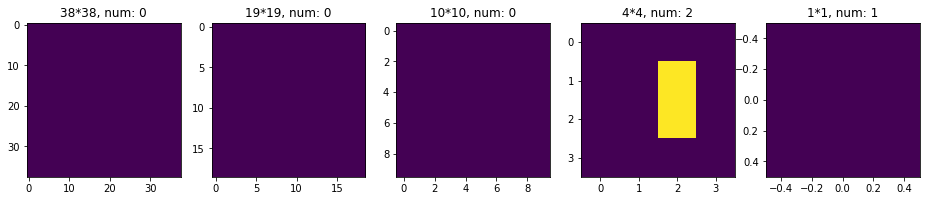

anchor index: 3


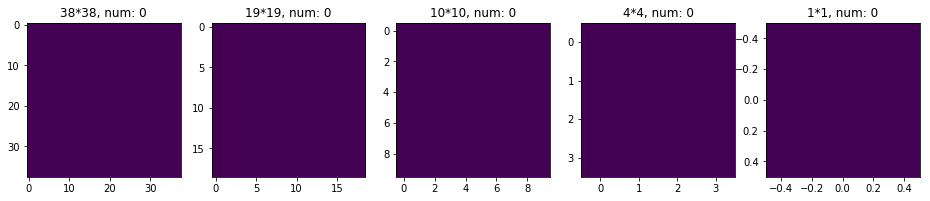

anchor index: 4


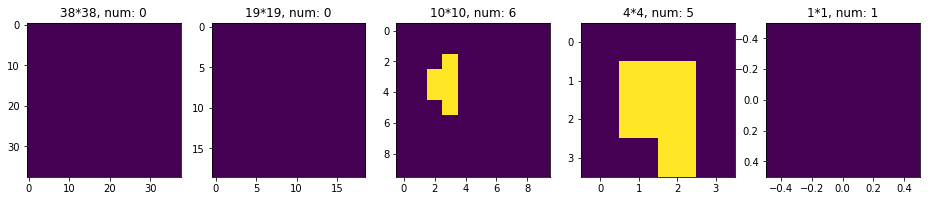

anchor index: 5


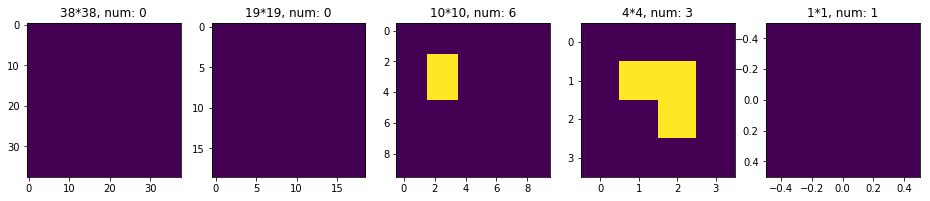

negative samples on each feature map:
img 1: positives: 150.0, negatives: 450.0


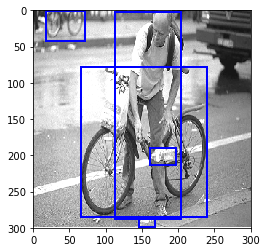

positive samples on each feature map:
anchor index: 0


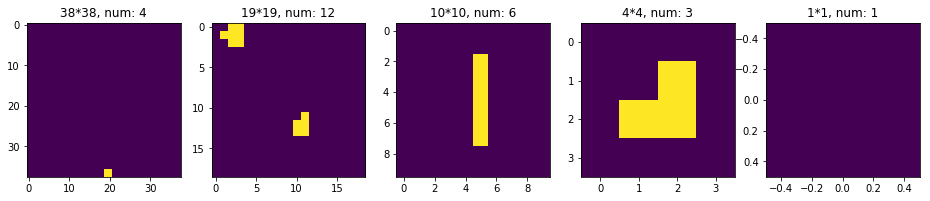

anchor index: 1


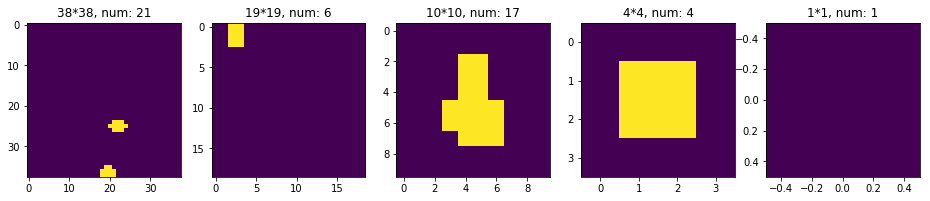

anchor index: 2


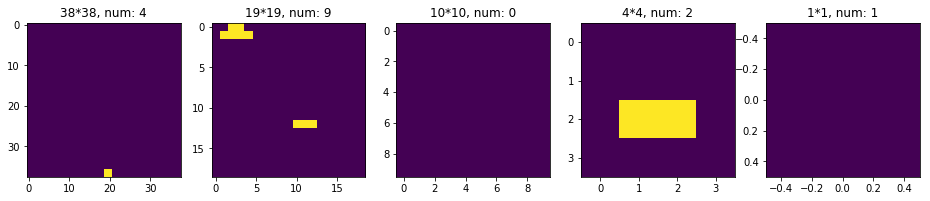

anchor index: 3


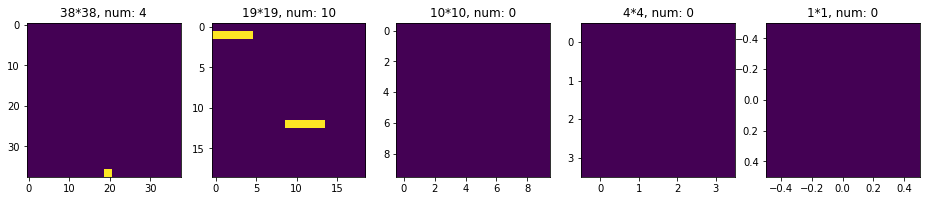

anchor index: 4


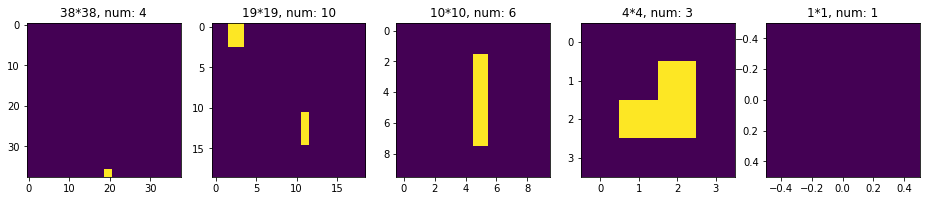

anchor index: 5


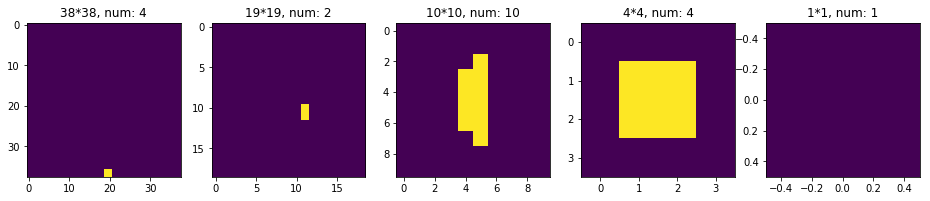

negative samples on each feature map:
img 2: positives: 60.0, negatives: 180.0


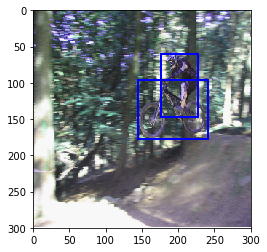

positive samples on each feature map:
anchor index: 0


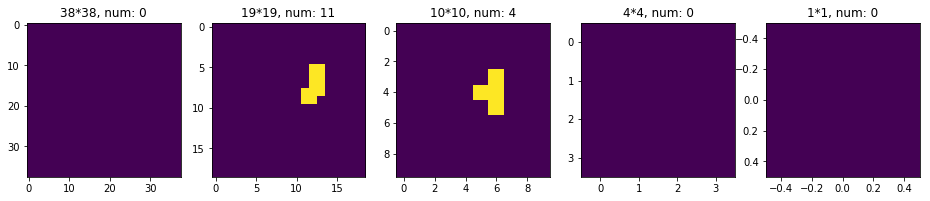

anchor index: 1


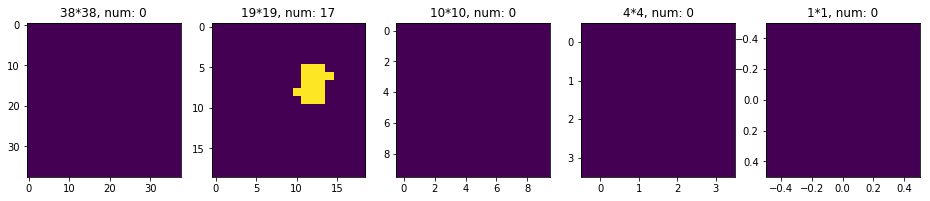

anchor index: 2


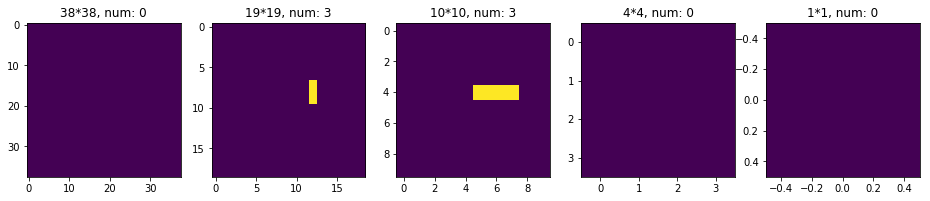

anchor index: 3


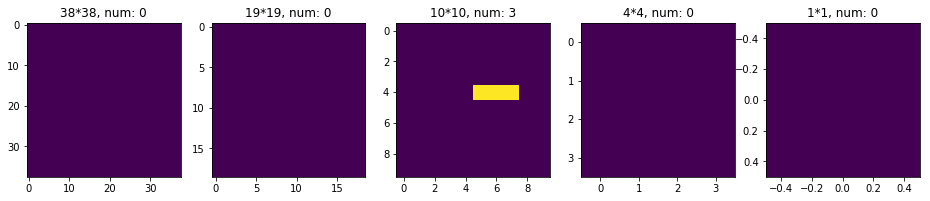

anchor index: 4


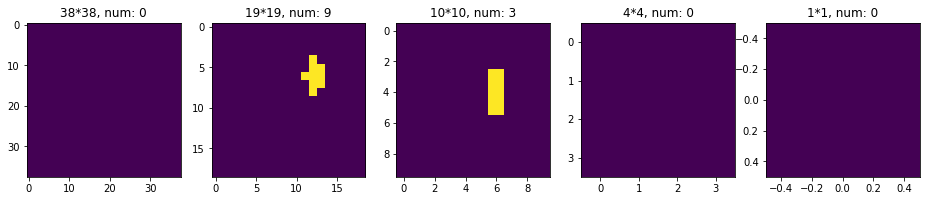

anchor index: 5


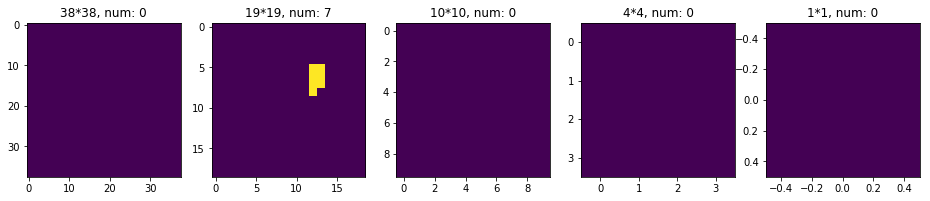

negative samples on each feature map:
img 3: positives: 210.0, negatives: 630.0


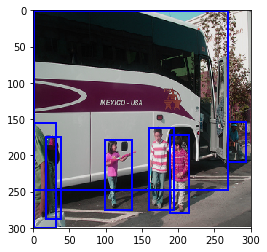

positive samples on each feature map:
anchor index: 0


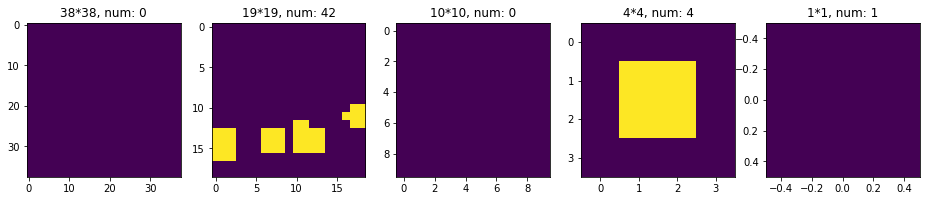

anchor index: 1


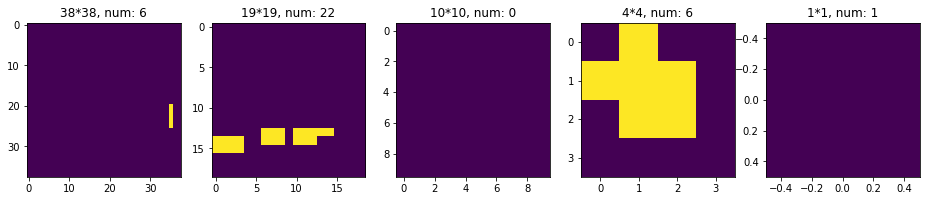

anchor index: 2


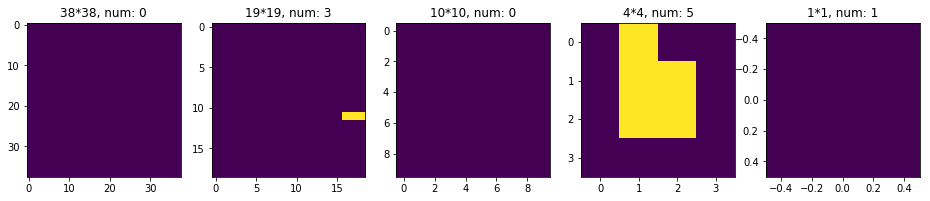

anchor index: 3


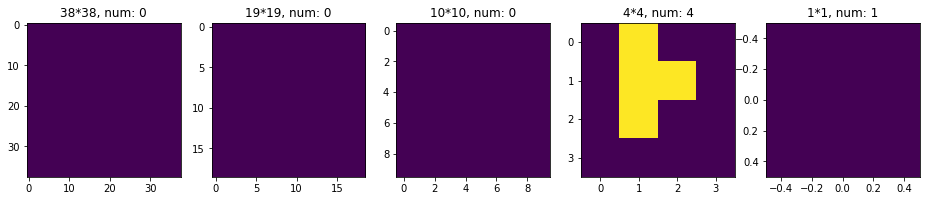

anchor index: 4


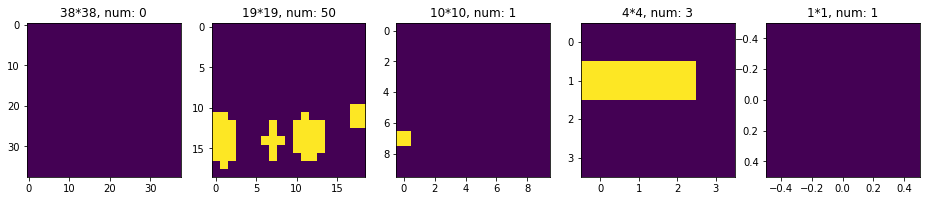

anchor index: 5


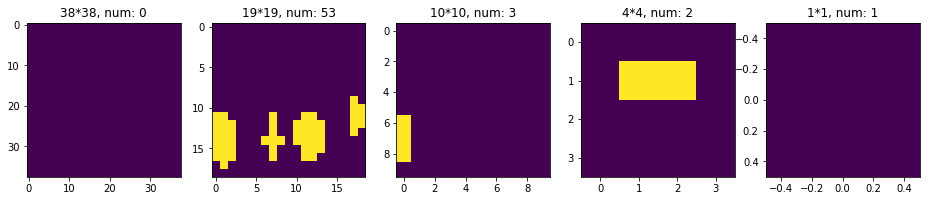

negative samples on each feature map:
img 4: positives: 30.0, negatives: 90.0


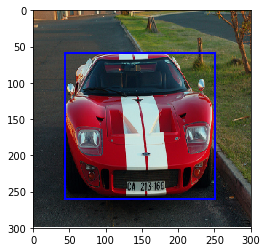

positive samples on each feature map:
anchor index: 0


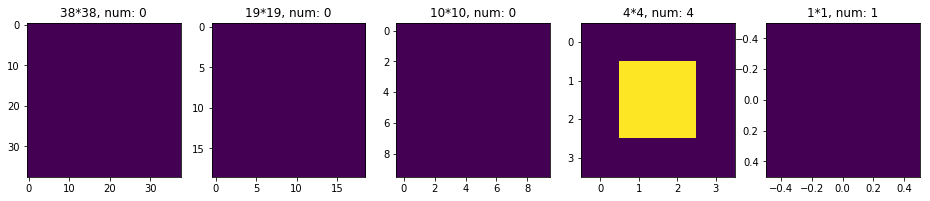

anchor index: 1


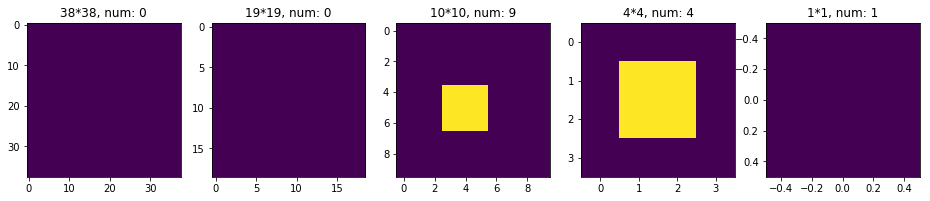

anchor index: 2


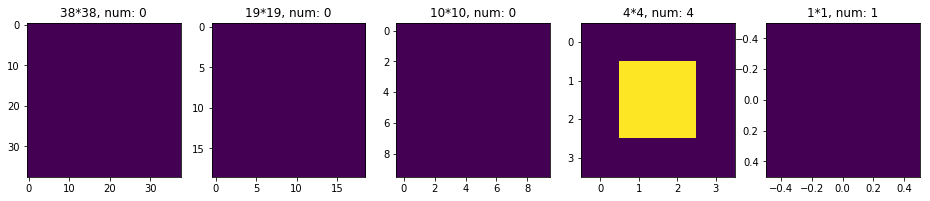

anchor index: 3


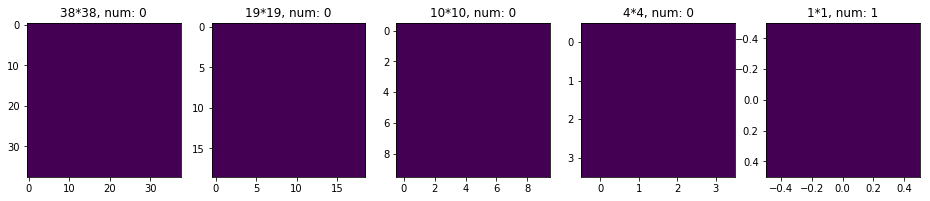

anchor index: 4


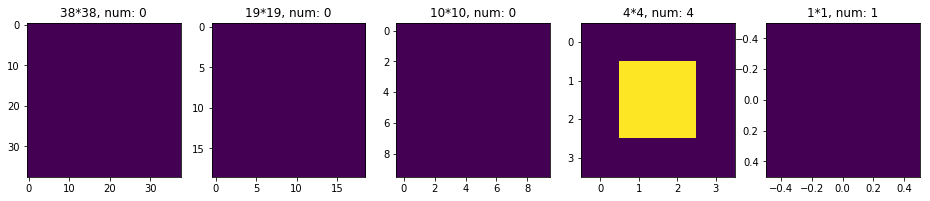

anchor index: 5


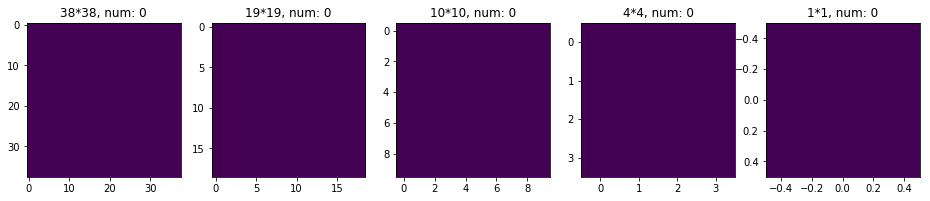

negative samples on each feature map:
img 5: positives: 30.0, negatives: 90.0


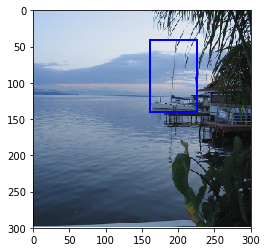

positive samples on each feature map:
anchor index: 0


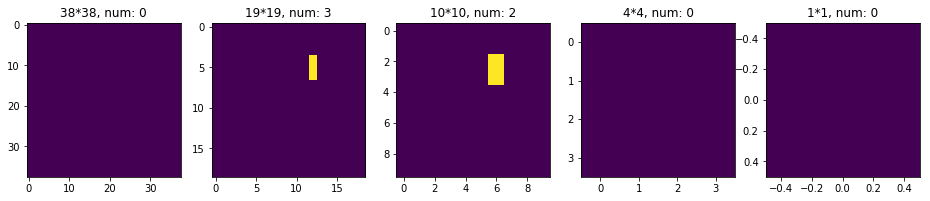

anchor index: 1


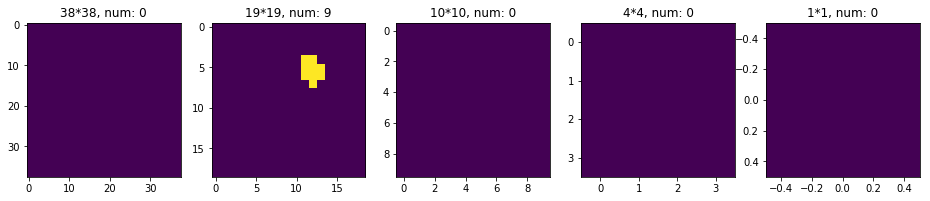

anchor index: 2


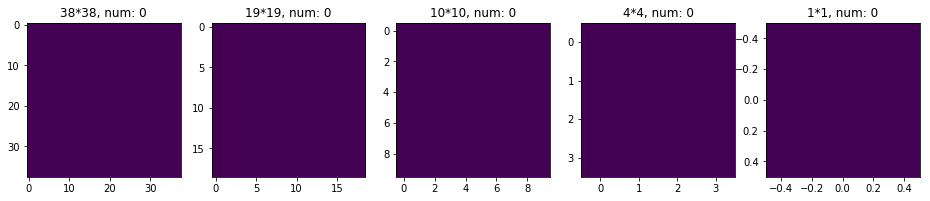

anchor index: 3


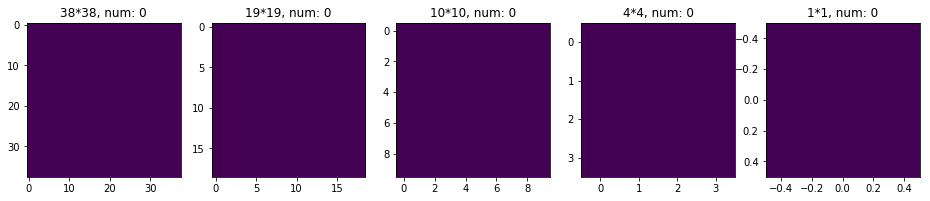

anchor index: 4


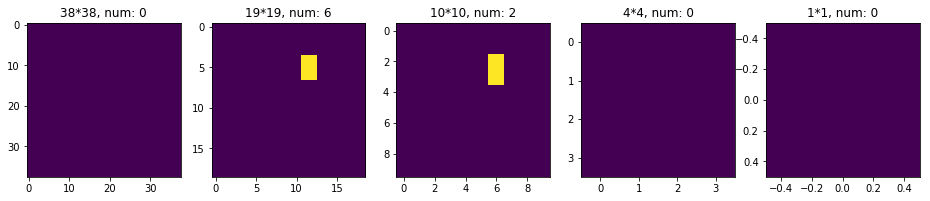

anchor index: 5


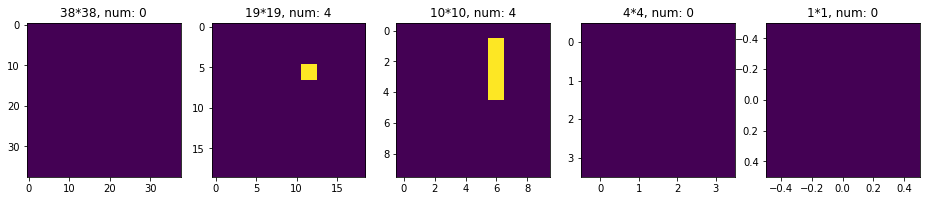

negative samples on each feature map:
img 6: positives: 60.0, negatives: 180.0


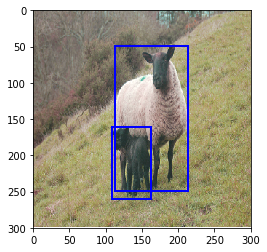

positive samples on each feature map:
anchor index: 0


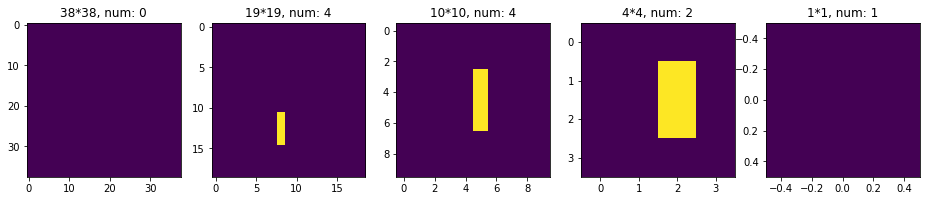

anchor index: 1


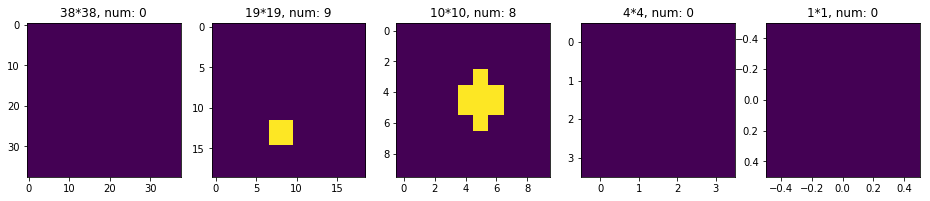

anchor index: 2


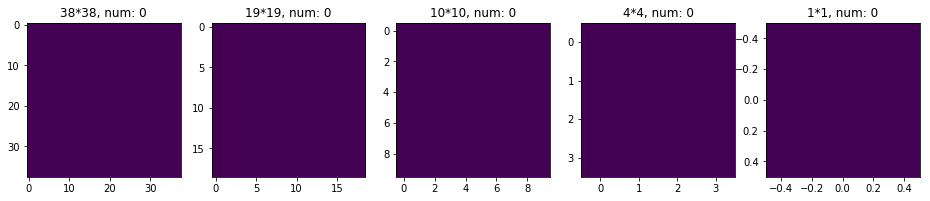

anchor index: 3


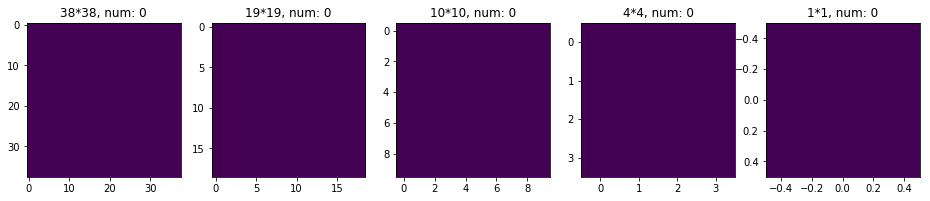

anchor index: 4


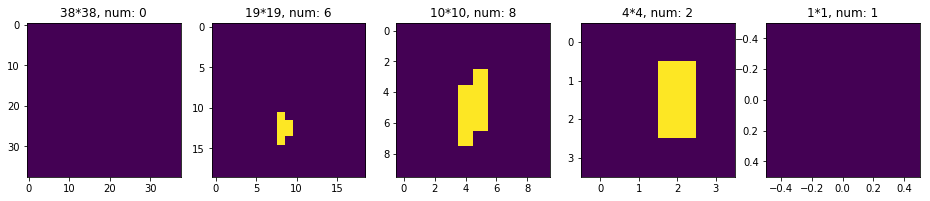

anchor index: 5


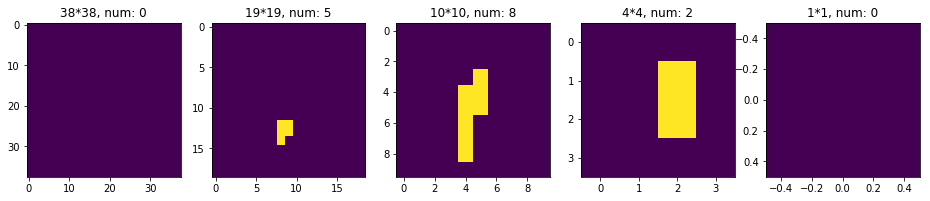

negative samples on each feature map:
img 7: positives: 60.0, negatives: 180.0


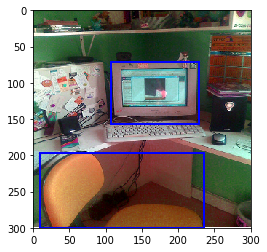

positive samples on each feature map:
anchor index: 0


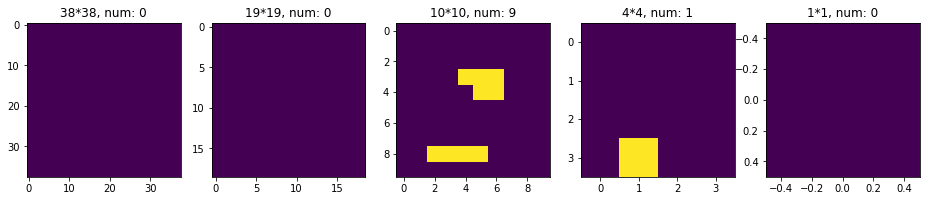

anchor index: 1


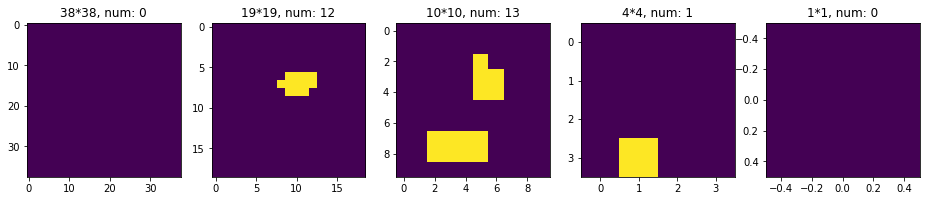

anchor index: 2


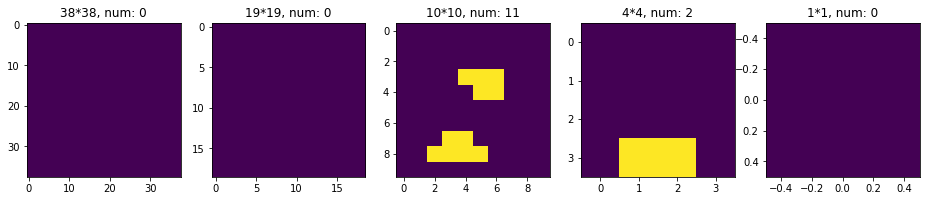

anchor index: 3


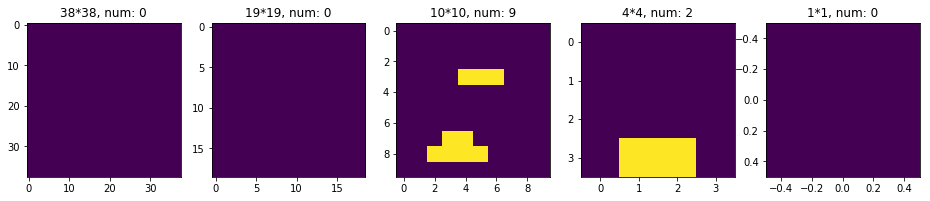

anchor index: 4


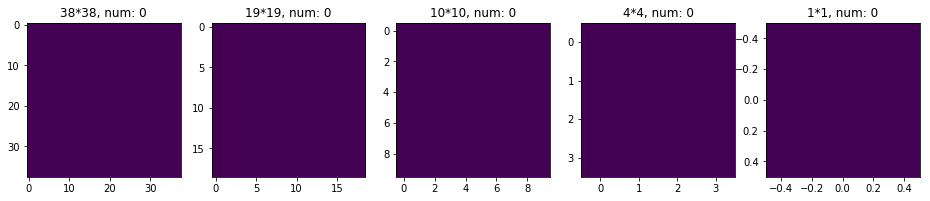

anchor index: 5


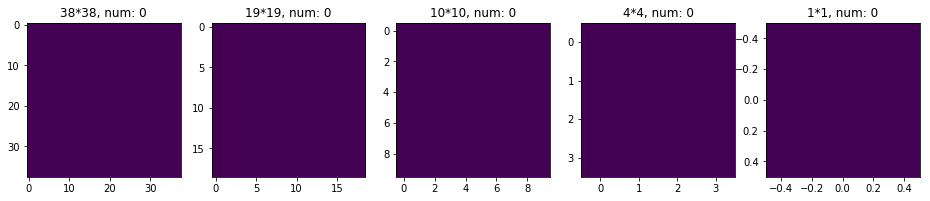

negative samples on each feature map:
img 8: positives: 120.0, negatives: 360.0


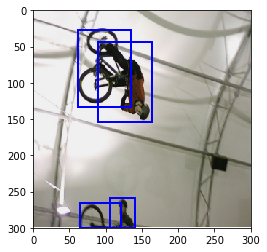

positive samples on each feature map:
anchor index: 0


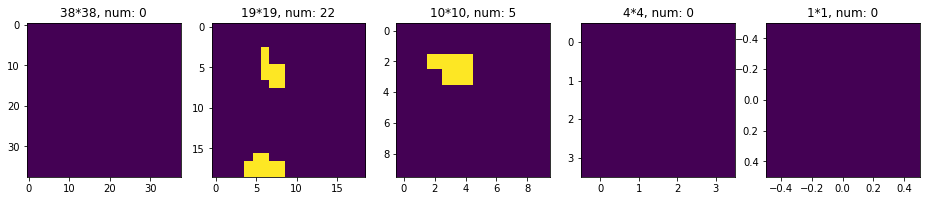

anchor index: 1


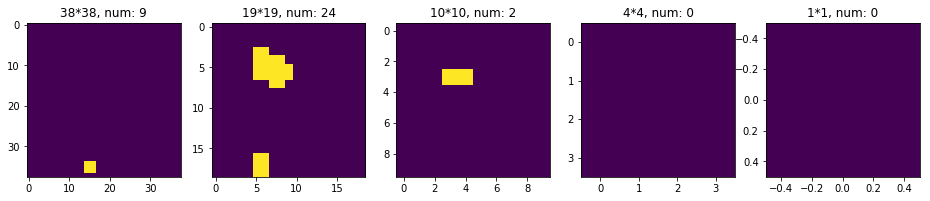

anchor index: 2


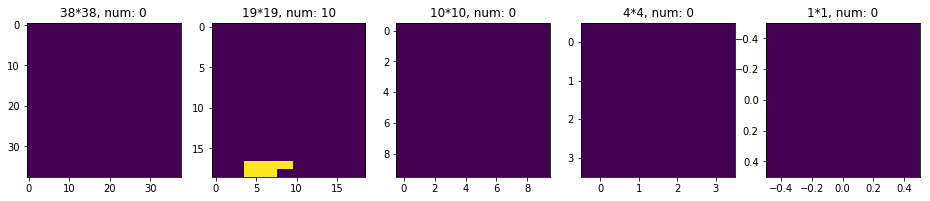

anchor index: 3


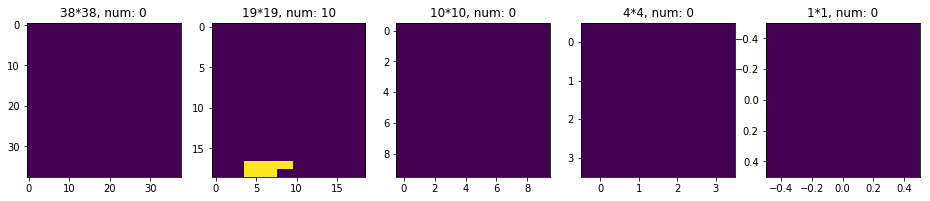

anchor index: 4


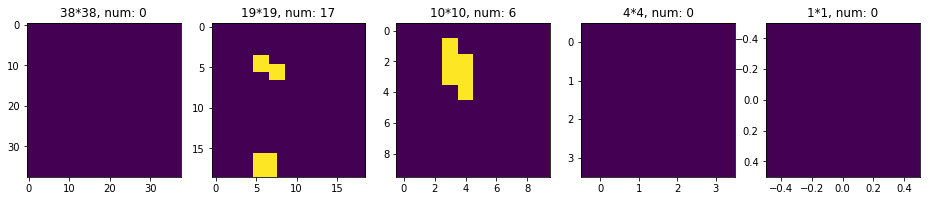

anchor index: 5


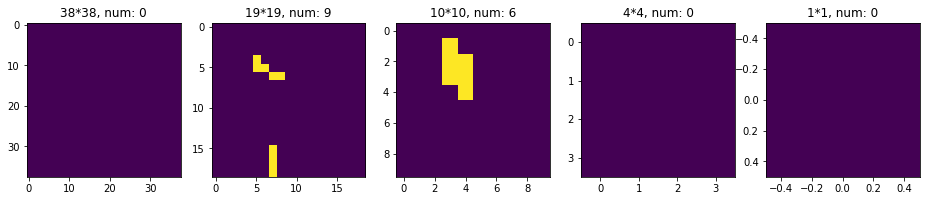

negative samples on each feature map:
img 9: positives: 240.0, negatives: 720.0


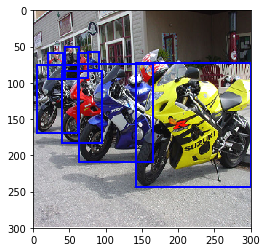

positive samples on each feature map:
anchor index: 0


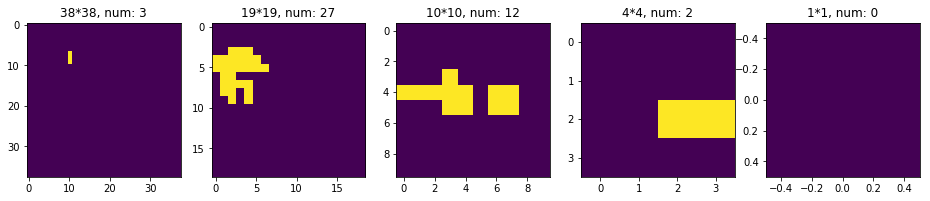

anchor index: 1


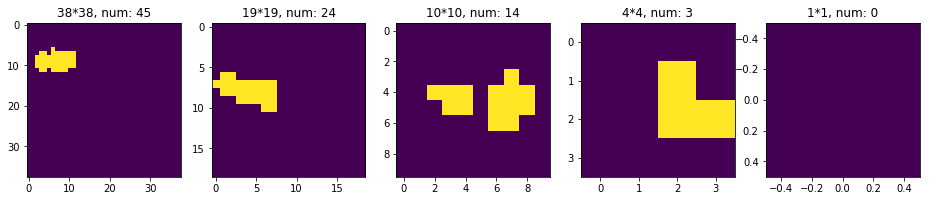

anchor index: 2


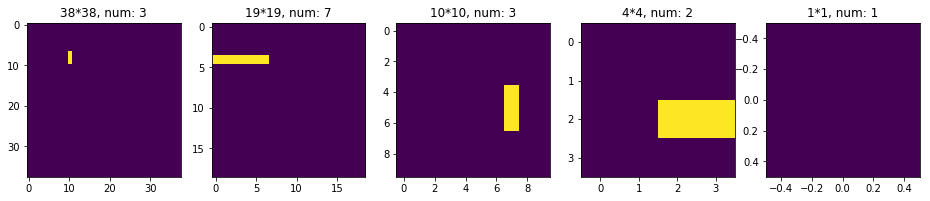

anchor index: 3


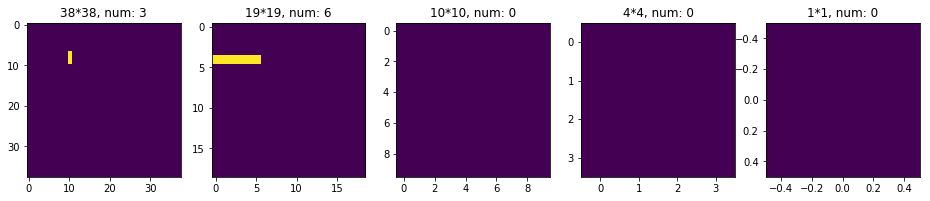

anchor index: 4


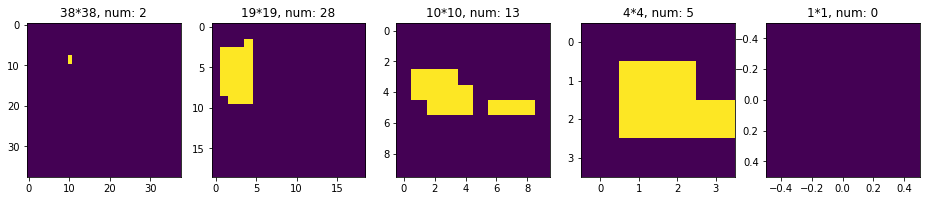

anchor index: 5


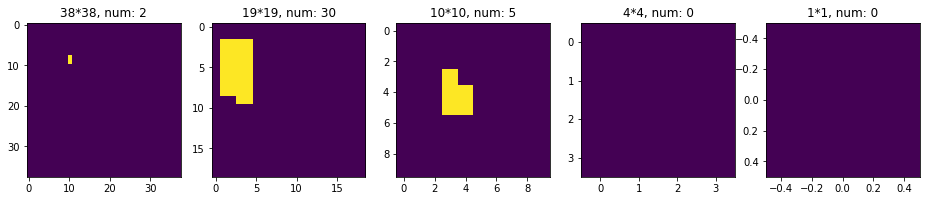

negative samples on each feature map:


In [12]:
importlib.reload(ssd_utils_test)
importlib.reload(ssd_utils)
ssd_utils_test.test_generate_target(mx_imgs, mx_labels, ssd)

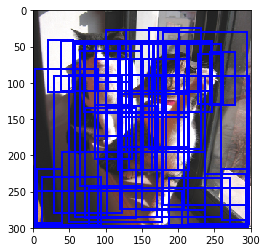

(62, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[7.         0.152      0.094      0.4853333  0.672     ]
 [7.         0.29866666 0.198      0.848      0.99599993]]


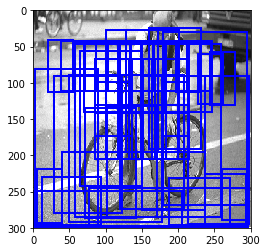

(58, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[1.0000000e+00 2.2000000e-01 2.6182964e-01 7.9799998e-01 9.4952679e-01]
 [1.0000000e+00 5.7999998e-02 3.1545742e-03 2.3800001e-01 1.3880126e-01]
 [1.4000000e+01 3.7799999e-01 6.3091484e-03 6.8199998e-01 9.5899045e-01]
 [4.0000000e+00

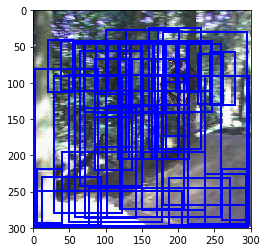

(58, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[ 1.          0.484       0.32        0.802       0.592     ]
 [14.          0.588       0.2         0.76        0.49066666]]


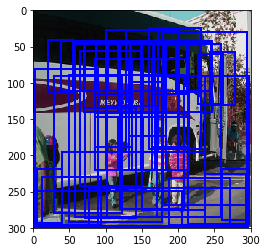

(61, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[1.4000000e+01 2.0000001e-03 5.1733333e-01 1.0600000e-01 1.0000000e+00]
 [1.4000000e+01 5.7999998e-02 5.8399999e-01 1.2800001e-01 9.5999998e-01]
 [1.4000000e+01 3.3199999e-01 5.9733331e-01 4.5400000e-01 9.1733325e-01]
 [1.4000000e+01

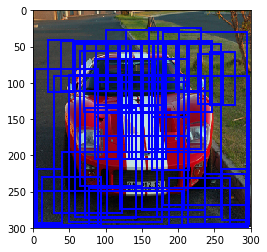

(61, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[6.         0.144      0.19578314 0.834      0.8674699 ]]


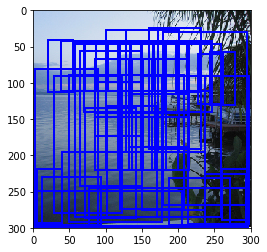

(61, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[3.         0.536      0.13409092 0.752      0.46818182]]


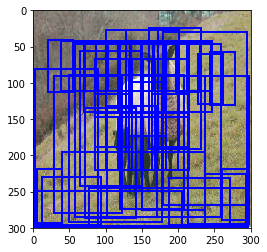

(61, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[16.          0.362       0.5345345   0.544       0.8678678 ]
 [16.          0.374       0.16216215  0.714       0.8288288 ]]


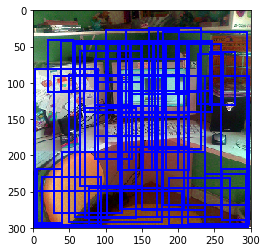

(62, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[19.          0.36        0.238       0.76266664  0.524     ]
 [ 8.          0.02933333  0.654       0.784       1.        ]]


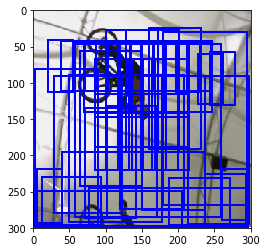

(62, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[ 1.          0.208       0.09009009  0.44800004  0.44444442]
 [14.          0.298       0.14414415  0.546       0.5135135 ]
 [14.          0.352       0.8648649   0.46600002  1.        ]
 [ 1.          0.21399999  0.88588595  0.406 

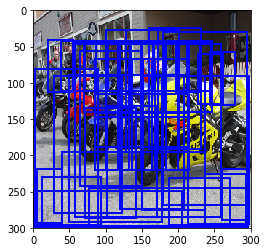

(62, 6)
[[ 0.1299774  14.          0.19091946  0.15286168  0.8634755   0.95024157]
 [ 0.12685522 10.          0.          0.82919353  0.6851449   0.99423605]
 [ 0.1226116  10.          0.2580781   0.8153449   0.98861396  0.99613035]
 [ 0.12074503 14.          0.1629842   0.2950548   0.5932248   0.971079  ]
 [ 0.11777449 10.          0.13164386  0.6502239   0.79218876  0.99086446]
 [ 0.1124134   8.          0.7911227   0.75465834  0.97661185  0.99386656]
 [ 0.11212558 14.          0.71107924  0.30153874  0.9934803   0.98360014]
 [ 0.11055412 14.          0.39946696  0.2989618   0.69303596  0.9129367 ]
 [ 0.10932837 14.          0.28689885  0.14518261  0.39701384  0.3729877 ]
 [ 0.10931654 14.          0.33952808  0.14518555  0.44964433  0.3729931 ]]
label: [[13.          0.47200003  0.24        1.          0.81333333]
 [13.          0.21        0.24800001  0.552       0.6986667 ]
 [13.          0.134       0.27733332  0.318       0.6106667 ]
 [13.          0.016       0.25333333  0.204 

In [9]:
importlib.reload(ssd_utils_test)
importlib.reload(ssd_utils)
ssd_utils_test.test_get_pred_scores_classes_and_boxes(mx_imgs, mx_labels, ssd, anchors)

## test phase

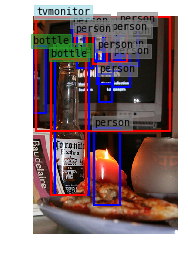

In [14]:
img, label = dataset[3]
mx_img, mx_label = myutils.prepare_datum_for_net(img, label, ssd.get_transform_fn())
tensor_preds = ssd(mx_img.as_in_context(ssd.ctx))
scores_cls_boxes = ssd_utils.get_pred_scores_classes_and_boxes(tensor_preds, img.shape[:2], ssd.get_anchors())
myutils.visualize_pred(img, label, scores_cls_boxes, dataset.class_names, show_label=True)
fig = plt.gcf()
plt.show()

## Validation

In [4]:
ssd.load_parameters('D:\Documents\Data_Files\Parameters\ssd_ohem+dynamic_45_epoches', ctx=ssd.ctx)

In [55]:
importlib.reload(ssd_utils)
importlib.reload(myutils)
metric = gcv.utils.metrics.voc_detection.VOCMApMetric(iou_thresh=0.5, class_names=dataset_val.class_names)
metric.reset()
i = 0
tic_total = time.time()
for imgs, labels in dataloader_val:
    imgs, labels = myutils.transform_list_mx_to_list(imgs, labels)
    mx_imgs, img_sizes, batch_labels = myutils.transform_imgs_labels_to_val_batch(imgs, labels,
                                                                                 ssd.get_transform_fn(),
                                                                                 myutils.batchify_fn)
    tensor_preds = ssd(mx_imgs.as_in_context(ssd.ctx))
    batch_scores_cls_boxes = ssd_utils.get_pred_scores_classes_and_boxes_for_matric(tensor_preds, img_sizes, ssd.get_anchors())
    pred_bboxes, pred_labels, pred_scores, gt_boxes, gt_labels = myutils.parse_batch_detection_outputs(batch_scores_cls_boxes, batch_labels)
    metric.update(pred_bboxes, pred_labels, pred_scores, gt_boxes, gt_labels)
toc_total = time.time()
print('total time spent:', toc_total - tic_total)
print(list(zip(metric.get()[0], metric.get()[1])))

total time spent: 250.09831428527832
[('aeroplane', 0.34207490947297814), ('bicycle', 0.16889171727057486), ('bird', 0.053001087366662515), ('boat', 0.01578919620511668), ('bottle', 0.002503076827108744), ('bus', 0.3912671095571324), ('car', 0.13185936693679806), ('cat', 0.3301676924474671), ('chair', 0.013027059983583694), ('cow', 0.00831533675955874), ('diningtable', 0.018938130333908156), ('dog', 0.15751516949230035), ('horse', 0.14751259475372475), ('motorbike', 0.2599162222601587), ('person', 0.17621401705754206), ('pottedplant', 0.005056174942714929), ('sheep', 0.05680013948654497), ('sofa', 0.038610897099314506), ('train', 0.24501196850965126), ('tvmonitor', 0.048160391736912465), ('mAP', 0.13053161292498766)]
